In [1]:
from IPython import get_ipython

ipython = get_ipython()
# Code to automatically update the TransformerLens code as its edited without restarting the kernel
ipython.magic("load_ext autoreload")
ipython.magic("autoreload 2")
    
import plotly.io as pio
# pio.renderers.default = "png"
# Import stuff
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np
import einops
from fancy_einsum import einsum
import tqdm.notebook as tqdm
import random
from pathlib import Path
import plotly.express as px
from torch.utils.data import DataLoader

from jaxtyping import Float, Int
from typing import List, Union, Optional
from functools import partial
import copy

import itertools
from transformers import AutoModelForCausalLM, AutoConfig, AutoTokenizer
import dataclasses
import datasets
from IPython.display import HTML

from tqdm import tqdm


/tmp/ipykernel_95300/1348182768.py:5: DeprecationWarning: `magic(...)` is deprecated since IPython 0.13 (warning added in 8.1), use run_line_magic(magic_name, parameter_s).
  ipython.magic("load_ext autoreload")
/tmp/ipykernel_95300/1348182768.py:6: DeprecationWarning: `magic(...)` is deprecated since IPython 0.13 (warning added in 8.1), use run_line_magic(magic_name, parameter_s).
  ipython.magic("autoreload 2")


In [2]:
# import pysvelte
# 
import transformer_lens
import transformer_lens.utils as utils
from transformer_lens.hook_points import (
    HookedRootModule,
    HookPoint,
)  # Hooking utilities
from transformer_lens import HookedTransformer, HookedTransformerConfig, FactoredMatrix, ActivationCache

torch.set_grad_enabled(False)
device = "cpu"

In [3]:
model = HookedTransformer.from_pretrained(
    "gpt2-xl",
    center_unembed=False,
    center_writing_weights=False,
    fold_ln=False,
    refactor_factored_attn_matrices=True,
    device=device
)

model.cfg.total_heads = model.cfg.n_heads * model.cfg.n_layers

Using pad_token, but it is not set yet.


Loaded pretrained model gpt2-xl into HookedTransformer


In [4]:
def query_logits(logits, return_type = "logits", TOP_N = 10):

        """
        Gets top 10 predictions after last token in a prompt
        """
        last_tok_logits = logits[0, -1]
        
        #gets probs after last tok in seq
        
        if return_type == "probs":
            scores = F.softmax(last_tok_logits, dim=-1).detach().cpu().numpy() #the [0] is to index out of the batch idx
        else:
            scores = last_tok_logits.detach().cpu().numpy()

        #assert probs add to 1
        # assert np.abs(np.sum(probs) - 1) <= 0.01, str(np.abs(np.sum(probs)-1)) 

        probs_ = []
        for index, prob in enumerate(scores):
            probs_.append((index, prob))

        top_k = sorted(probs_, key = lambda x: x[1], reverse = True)[:TOP_N]
        top_k = [(t[1].item(), model.tokenizer.decode(t[0])) for t in top_k]
        
        return top_k
    
def is_logits_contain_label(ranked_logits, correct_answer):
    # Convert correct_answer to lower case and strip white space
    correct_answer = correct_answer.strip().lower()

    # Loop through the top 10 logits
    for logit_score, logit_value in ranked_logits:
        # Convert logit_value to lower case and strip white space
        logit_value = logit_value.strip().lower()

        # Check if the correct answer contains the logit value
        if correct_answer.find(logit_value) != -1: 
            return True
    return False


In [5]:
import random
import pandas as pd
from torch.utils.data import Dataset

class CapitalsDataset(Dataset):
    def __init__(self, csv_file, with_space):
        # Load the dataset
        self.dataframe = pd.read_csv(csv_file)
        self.with_space = with_space

    def __len__(self):
        # Return the length of the dataset
        return len(self.dataframe)

    def __getitem__(self, idx):
        #idx must be int
        if torch.is_tensor(idx):
            idx = idx.tolist()

        # Get the country and capital at the provided index
        country = self.dataframe.at[idx, 'country']
        capital = self.dataframe.at[idx, 'capital']

        # Format the input and label strings
        input_string = f"Q: What is the capital of {str(country)}? A:"
        if self.with_space:
            input_string += " \xa0"
        label_string = f"{str(capital)}"

        # Return a dict with the input and label
        sample = {'input': input_string, 'label': label_string}
        return sample

def generate_few_shot_prompt(capitals_dataset, n_few_shot, prohibited_indices=[], prop_wrong = 0):
    # Get a list of allowed indices (all indices not in prohibited_indices)
    allowed_indices = [i for i in range(len(capitals_dataset)) if i not in prohibited_indices]

    # Ensure n_few_shot is not greater than the size of the dataset
    n_few_shot = min(n_few_shot, len(allowed_indices))

    # Randomly select n_few_shot indices from the allowed indices without replacement
    indices = random.sample(allowed_indices, n_few_shot)

    # Generate the few-shot prompt
    prompt = ""
    for index in indices:
        sample = capitals_dataset[index]
        
        if np.random.rand() < prop_wrong:
            allowed_indices = [i for i in range(len(capitals_dataset)) if i not in (prohibited_indices + [index])]

            diff_idx = random.sample(allowed_indices, 1)[0]
                        
            prompt += f"{sample['input']} {capitals_dataset[diff_idx]['label']}\n"
        else:  
            prompt += f"{sample['input']} {sample['label']}\n"
        
    return prompt

In [6]:
# Create the original dataset with spaces
capitals_dataset_space = CapitalsDataset(csv_file='world_capitals.csv', with_space=True)

# Create the new dataset
few_shot_capitals_space_prompts = []
n_few_shot = 0 # Set this to your desired number of few-shot examples
for i in range(len(capitals_dataset_space)):
    # Generate a few-shot prompt without the current index
    prompt = generate_few_shot_prompt(capitals_dataset_space, n_few_shot, prohibited_indices=[i])

    # Get the current sample and add the prompt to the 'input'
    sample = capitals_dataset_space[i]
    sample['input'] = prompt + sample['input']

    # Add the sample to the new dataset
    few_shot_capitals_space_prompts.append(sample)

# Create the original dataset with spaces
capitals_dataset_no_space = CapitalsDataset(csv_file='world_capitals.csv', with_space=False)

# Create the new dataset
few_shot_capitals_no_space_prompts = []
for i in range(len(capitals_dataset_no_space)):
    # Generate a few-shot prompt without the current index
    prompt = generate_few_shot_prompt(capitals_dataset_no_space, n_few_shot, prohibited_indices=[i])

    # Get the current sample and add the prompt to the 'input'
    sample = capitals_dataset_no_space[i]
    sample['input'] = prompt + sample['input']

    # Add the sample to the new dataset
    few_shot_capitals_no_space_prompts.append(sample)


In [7]:
few_shot_capitals_space_prompts[0]

{'input': 'Q: What is the capital of Abkhazia? A: \xa0', 'label': 'Sukhumi'}

In [8]:
country_test = "Zimbabwe"

logits = model(f"The capital of {country_test} is the city of")
ranked_logits = query_logits(logits, TOP_N = 10)
print(ranked_logits)


logits = model(f"The capital of {country_test} is the city of \xa0")
ranked_logits = query_logits(logits, TOP_N = 10)
print(ranked_logits)

[(16.87539291381836, ' Har'), (13.011051177978516, ' Bul'), (9.19929027557373, ' Victoria'), (9.131611824035645, ' Zimbabwe'), (8.693876266479492, ' Mug'), (8.677135467529297, ' Dar'), (8.539237022399902, ' Mash'), (8.513354301452637, ' M'), (8.46098518371582, ' Mar'), (8.221226692199707, ' Bl')]
[(12.76206111907959, ' Har'), (9.672176361083984, ' Bul'), (8.233769416809082, ' Zimbabwe'), (8.147758483886719, ' Mash'), (7.993024826049805, ' Mug'), (7.861281871795654, ' Victoria'), (7.585323333740234, ' M'), (7.412278652191162, ' L'), (7.350394248962402, '\xa0'), (7.305417060852051, ' G')]


In [9]:
# WITH A SPACE
n_correct = 0 
dataset_size=50
for row in tqdm(few_shot_capitals_space_prompts[:dataset_size]):
    prompt = row["input"]
    label = row["label"]

    logits = model(prompt)
    # print(logits)
    
    ranked_logits = query_logits(logits, TOP_N = 10)
    # print(ranked_logits)
    # print(label)
    
    if is_logits_contain_label(ranked_logits, label):
        n_correct +=1
        row["model_correct"] = 1
    else:
        row["model_correct"] = 0
    
n_correct / len(few_shot_capitals_space_prompts[:dataset_size])

100%|██████████| 50/50 [00:09<00:00,  5.44it/s]


1.0

In [10]:
# WITHOUT A SPACE
n_correct = 0 
dataset_size=50
for row in tqdm(few_shot_capitals_no_space_prompts[:dataset_size]):
    prompt = row["input"]
    label = row["label"]

    logits = model(prompt)
    
    ranked_logits = query_logits(logits, TOP_N = 10)
    
    if is_logits_contain_label(ranked_logits, label):
        n_correct +=1
        row["model_correct"] = 1
    else:
        row["model_correct"] = 0
    # print(ranked_logits)
    # print(label)
    
n_correct / len(few_shot_capitals_no_space_prompts[:dataset_size])

100%|██████████| 50/50 [00:09<00:00,  5.45it/s]


0.96

# Logit Lens

In [11]:
# look through ranked logits and see which 
def get_logit_val(logits, capital_string):
    first_token_of_capital = model.to_str_tokens(capital_string)[1]
    print(first_token_of_capital)

    ranked_logits = query_logits(logits, TOP_N=10000)
    for logit in ranked_logits:
        if first_token_of_capital.lower() in logit[1].lower():
            return logit[1], logit[0]

    # if we get here, very bad
    print("Capital not found in ranked logits. Uh Oh!")
    return capital_string, -1e5

In [12]:
logits = model(f"The capital of China is the city of")
print(query_logits(logits, TOP_N=100))
get_logit_val(logits, "Beijing")

[(12.729573249816895, ' Beijing'), (10.71007251739502, ' Shanghai'), (10.24016284942627, ' Chong'), (9.549708366394043, ' Xi'), (9.545827865600586, ' Cheng'), (9.298571586608887, ' Guang'), (9.287895202636719, ' Tian'), (9.276071548461914, ' Nan'), (9.256789207458496, ' Shen'), (9.134026527404785, ' Tai'), (8.986799240112305, ' Chang'), (8.730999946594238, ' Qing'), (8.702823638916016, ' Hong'), (8.387773513793945, ' W'), (8.185921669006348, ' Hang'), (7.906286716461182, ' Suz'), (7.693309307098389, ' X'), (7.6402907371521, ' Yang'), (7.4890594482421875, ' Sh'), (7.438599586486816, ' Har'), (7.336167335510254, ' Y'), (7.335968971252441, ' D'), (7.206343650817871, ' Ning'), (7.080493927001953, ' the'), (7.046160697937012, ' Zheng'), (6.978892803192139, ' Zh'), (6.690622329711914, ' New'), (6.613645553588867, ' P'), (6.58955192565918, ' Tokyo'), (6.585175037384033, ' San'), (6.575978755950928, ' Kun'), (6.509332656860352, ' L'), (6.508543014526367, ' Z'), (6.490668296813965, ' London'), 

(' Beijing', 12.729573249816895)

In [13]:
# print(torch.nn.functional.one_hot(torch.tensor([model.to_single_token(" Beijing")]), num_classes=model.cfg.d_vocab) @ model.W_E)

model.W_E[model.to_single_token(" Beijing")]
# torch.nn.functional.one_hot(torch.tensor([model.to_single_token(" Beijing")]), num_classes=model.cfg.d_vocab)


tensor([ 0.0123,  0.0551,  0.0088,  ...,  0.0188, -0.0055, -0.0230],
       requires_grad=True)

In [14]:
# Get the direction in embedding space
def get_direction_in_embedding_space(model, capital_token):
    return model.W_E[model.to_single_token(capital_token)]

print(model.W_U.shape)

torch.Size([1600, 50257])


In [15]:
# final_ln_output should be in direction __ to maximize 

In [16]:
capital_test = []
for i in range(len(capitals_dataset_no_space)):
    # Generate a few-shot prompt without the current index
    prompt = generate_few_shot_prompt(capitals_dataset_no_space, n_few_shot, prohibited_indices=[i])

    # Get the current sample and add the prompt to the 'input'
    sample = capitals_dataset_no_space[i]
    sample['input'] = prompt + sample['input']

    # Add the sample to the new dataset
    capital_test.append(sample)



In [17]:
# dict for all train lengths
train_tokens_dict = {}


for row in capital_test:
    prompt = row["input"]
    label = row["label"]

    logits = model(prompt)
    tokenized_prompt = model.to_tokens(prompt)
    if tokenized_prompt.shape[1] not in train_tokens_dict:
        train_tokens_dict[tokenized_prompt.shape[1]] = []
    train_tokens_dict[tokenized_prompt.shape[1]].append(tokenized_prompt)
    # print(f"{prompt}, {label}")
    # print(get_logit_val(logits, label))

In [18]:
print(train_tokens_dict.keys())
for value in train_tokens_dict.values():
    print(len(value))

# print(train_tokens_dict[12])
len_12_tokens = torch.Tensor(len(train_tokens_dict[12]), 12)
torch.cat(train_tokens_dict[12], out=len_12_tokens)

dict_keys([15, 12, 19, 13, 14, 17, 18, 16, 20])
18
125
2
57
28
6
6
4
2


tensor([[5.0256e+04, 4.8000e+01, 2.5000e+01,  ..., 3.0000e+01, 3.1700e+02,
         2.5000e+01],
        [5.0256e+04, 4.8000e+01, 2.5000e+01,  ..., 3.0000e+01, 3.1700e+02,
         2.5000e+01],
        [5.0256e+04, 4.8000e+01, 2.5000e+01,  ..., 3.0000e+01, 3.1700e+02,
         2.5000e+01],
        ...,
        [5.0256e+04, 4.8000e+01, 2.5000e+01,  ..., 3.0000e+01, 3.1700e+02,
         2.5000e+01],
        [5.0256e+04, 4.8000e+01, 2.5000e+01,  ..., 3.0000e+01, 3.1700e+02,
         2.5000e+01],
        [5.0256e+04, 4.8000e+01, 2.5000e+01,  ..., 3.0000e+01, 3.1700e+02,
         2.5000e+01]])

In [19]:
import os; os.environ["ACCELERATE_DISABLE_RICH"] = "1"
import sys
from functools import partial
import json
from typing import List, Tuple, Union, Optional, Callable, Dict
import torch as t
from torch import Tensor
from sklearn.linear_model import LinearRegression
import numpy as np
from plotly.subplots import make_subplots
import plotly.express as px
import plotly.graph_objects as go
import einops
from tqdm import tqdm
from jaxtyping import Float, Int, Bool
from pathlib import Path
import pandas as pd
import circuitsvis as cv
import webbrowser
from IPython.display import display
from transformer_lens import utils, ActivationCache, HookedTransformer, HookedTransformerConfig
from transformer_lens.hook_points import HookPoint
from transformer_lens.components import LayerNorm


In [20]:
def get_activations(
    model: HookedTransformer, 
    toks: Int[Tensor, "batch seq"], 
    names: Union[str, List[str]]
) -> Union[t.Tensor, ActivationCache]:
    '''
    Uses hooks to return activations from the model.

    If names is a string, returns the activations for that hook name.
    If names is a list of strings, returns a dictionary mapping hook names to tensors of activations.
    '''
    names_list = [names] if isinstance(names, str) else names
    _, cache = model.run_with_cache(
        toks,
        return_type=None,
        names_filter=lambda name: name in names_list,
    )

    return cache[names] if isinstance(names, str) else cache

def get_post_final_ln_dir(model: HookedTransformer, tok_index) -> Float[Tensor, "d_model"]:
    '''
    Returns the direction in which final_ln_output[0, :] should point to maximize P(unbalanced)
    '''
    # SOLUTION
    return model.W_U[:, tok_index]

def LN_hook_names(layernorm) -> Tuple[str, str]:
    '''
    Returns the names of the hooks immediately before and after a given layernorm.
    e.g. LN_hook_names(model.ln_final) returns ["blocks.2.hook_resid_post", "ln_final.hook_normalized"]
    '''
    if layernorm.name == "ln_final":
        input_hook_name = utils.get_act_name("resid_post", 2)
        output_hook_name = "ln_final.hook_normalized"
    else:
        layer, ln = layernorm.name.split(".")[1:]
        input_hook_name = utils.get_act_name("resid_pre" if ln=="ln1" else "resid_mid", layer)
        output_hook_name = utils.get_act_name('normalized', layer, ln)

    return input_hook_name, output_hook_name

def get_ln_fit(
    model: HookedTransformer, train_tokens, layernorm, seq_pos: Optional[int] = None
):
    '''
    if seq_pos is None, find best fit aggregated over all sequence positions. Otherwise, fit only for given seq_pos.

    Returns: A tuple of a (fitted) sklearn LinearRegression object and the r^2 of the fit
    '''
    input_hook_name, output_hook_name = LN_hook_names(layernorm)
    # SOLUTION

    activations_dict = get_activations(model, train_tokens, [input_hook_name, output_hook_name])
    inputs = utils.to_numpy(activations_dict[input_hook_name])
    outputs = utils.to_numpy(activations_dict[output_hook_name])

    if seq_pos is None:
        inputs = einops.rearrange(inputs, "batch seq d_model -> (batch seq) d_model")
        outputs = einops.rearrange(outputs, "batch seq d_model -> (batch seq) d_model")
    else:
        inputs = inputs[:, seq_pos, :]
        outputs = outputs[:, seq_pos, :]

    final_ln_fit = LinearRegression().fit(inputs, outputs)

    r2 = final_ln_fit.score(inputs, outputs)

    return (final_ln_fit, r2)

def get_pre_final_ln_dir(model: HookedTransformer, train_tokens) -> Float[Tensor, "d_model"]:
    '''
    Returns the direction in residual stream (pre ln_final, at sequence position 0) which
    most points in the direction of making an unbalanced classification.
    '''
    # SOLUTION
    post_final_ln_dir = get_post_final_ln_dir(model, -1)

    final_ln_fit = get_ln_fit(model, train_tokens, layernorm=model.ln_final, seq_pos=-1)[0]
    final_ln_coefs = t.from_numpy(final_ln_fit.coef_).to(device)

    return final_ln_coefs.T @ post_final_ln_dir

In [21]:
pre_final_ln_dir = get_pre_final_ln_dir(model, len_12_tokens.int())
print(pre_final_ln_dir.shape)

torch.Size([1600])


In [23]:
model.set_use_attn_result(True)
_, cache = model.run_with_cache(len_12_tokens.int())
print(cache)

print(cache[utils.get_act_name("result", 44)].shape)

ActivationCache with keys ['hook_embed', 'hook_pos_embed', 'blocks.0.hook_resid_pre', 'blocks.0.ln1.hook_scale', 'blocks.0.ln1.hook_normalized', 'blocks.0.attn.hook_q', 'blocks.0.attn.hook_k', 'blocks.0.attn.hook_v', 'blocks.0.attn.hook_attn_scores', 'blocks.0.attn.hook_pattern', 'blocks.0.attn.hook_z', 'blocks.0.attn.hook_result', 'blocks.0.hook_attn_out', 'blocks.0.hook_resid_mid', 'blocks.0.ln2.hook_scale', 'blocks.0.ln2.hook_normalized', 'blocks.0.mlp.hook_pre', 'blocks.0.mlp.hook_post', 'blocks.0.hook_mlp_out', 'blocks.0.hook_resid_post', 'blocks.1.hook_resid_pre', 'blocks.1.ln1.hook_scale', 'blocks.1.ln1.hook_normalized', 'blocks.1.attn.hook_q', 'blocks.1.attn.hook_k', 'blocks.1.attn.hook_v', 'blocks.1.attn.hook_attn_scores', 'blocks.1.attn.hook_pattern', 'blocks.1.attn.hook_z', 'blocks.1.attn.hook_result', 'blocks.1.hook_attn_out', 'blocks.1.hook_resid_mid', 'blocks.1.ln2.hook_scale', 'blocks.1.ln2.hook_normalized', 'blocks.1.mlp.hook_pre', 'blocks.1.mlp.hook_post', 'blocks.1.ho

In [36]:
head_num=19
layer=44


all_attributions = []
for layer in range(model.cfg.n_layers):
    attributions_layer = einops.einsum(cache[utils.get_act_name("result", layer)][:,-1], pre_final_ln_dir, "b n_h d_m, d_m -> b n_h").numpy()
    all_attributions.append(attributions_layer.mean(axis=0))

all_attributions = np.stack(all_attributions, axis=0)
all_attributions.shape

# head_output_logit_dir = einops.einsum(cache[utils.get_act_name("result", 44)][:,-1,head_num], pre_final_ln_dir, "b d_m, d_m -> b")
# px.histogram(head_output_logit_dir)

(48, 25)

In [51]:
model.to_str_tokens(model.tokenizer.batch_decode(len_12_tokens.int())[2])

['<|endoftext|>',
 '<|endoftext|>',
 'Q',
 ':',
 ' What',
 ' is',
 ' the',
 ' capital',
 ' of',
 ' Algeria',
 '?',
 ' A',
 ':']

In [50]:
px.imshow(cache[utils.get_act_name("pattern", 46)][:, 9].mean(axis = 0))

In [39]:
cache.keys()

dict_keys(['hook_embed', 'hook_pos_embed', 'blocks.0.hook_resid_pre', 'blocks.0.ln1.hook_scale', 'blocks.0.ln1.hook_normalized', 'blocks.0.attn.hook_q', 'blocks.0.attn.hook_k', 'blocks.0.attn.hook_v', 'blocks.0.attn.hook_attn_scores', 'blocks.0.attn.hook_pattern', 'blocks.0.attn.hook_z', 'blocks.0.attn.hook_result', 'blocks.0.hook_attn_out', 'blocks.0.hook_resid_mid', 'blocks.0.ln2.hook_scale', 'blocks.0.ln2.hook_normalized', 'blocks.0.mlp.hook_pre', 'blocks.0.mlp.hook_post', 'blocks.0.hook_mlp_out', 'blocks.0.hook_resid_post', 'blocks.1.hook_resid_pre', 'blocks.1.ln1.hook_scale', 'blocks.1.ln1.hook_normalized', 'blocks.1.attn.hook_q', 'blocks.1.attn.hook_k', 'blocks.1.attn.hook_v', 'blocks.1.attn.hook_attn_scores', 'blocks.1.attn.hook_pattern', 'blocks.1.attn.hook_z', 'blocks.1.attn.hook_result', 'blocks.1.hook_attn_out', 'blocks.1.hook_resid_mid', 'blocks.1.ln2.hook_scale', 'blocks.1.ln2.hook_normalized', 'blocks.1.mlp.hook_pre', 'blocks.1.mlp.hook_post', 'blocks.1.hook_mlp_out', 'bl

In [38]:
px.imshow(all_attributions, color_continuous_scale="RdBu", aspect="auto", origin="lower", title="Attributions for each head", color_continuous_midpoint=0)

In [22]:
model.set_use_attn_result(True)
def get_out_by_components(model: HookedTransformer, train_toks) -> Float[Tensor, "component batch seq_pos emb"]:
    '''
    Computes a tensor of shape [10, dataset_size, seq_pos, emb] representing the output of the model's components when run on the data.
    The first dimension is  [embeddings, head 0.0, head 0.1, mlp 0, head 1.0, head 1.1, mlp 1, head 2.0, head 2.1, mlp 2].
    The embeddings are the sum of token and positional embeddings.
    '''
    # SOLUTION
    embedding_hook_names = ["hook_embed", "hook_pos_embed"]
    head_hook_names = [utils.get_act_name("result", layer) for layer in range(model.cfg.n_layers)]
    mlp_hook_names = [utils.get_act_name("mlp_out", layer) for layer in range(model.cfg.n_layers)]

    all_hook_names = embedding_hook_names + head_hook_names + mlp_hook_names
    activations = get_activations(model, train_toks, all_hook_names)
    # print(activations)

    out = (activations["hook_embed"] + activations["hook_pos_embed"]).unsqueeze(0)

    for head_hook_name, mlp_hook_name in zip(head_hook_names, mlp_hook_names):
        out = t.concat([
            out, 
            einops.rearrange(activations[head_hook_name], "batch seq heads emb -> heads batch seq emb"),
            activations[mlp_hook_name].unsqueeze(0)
        ])

    return out

In [23]:
biases = model.b_O.sum(0)
out_by_components = get_out_by_components(model, len_12_tokens.int())
summed_terms = out_by_components.sum(dim=0) + biases

final_ln_input_name, final_ln_output_name = LN_hook_names(model.ln_final)
final_ln_input = get_activations(model, len_12_tokens.int(), final_ln_input_name)

print(summed_terms.shape)
print(final_ln_input.shape)

torch.Size([125, 12, 1024])
torch.Size([125, 12, 1024])


In [25]:
print(summed_terms.norm())
print(final_ln_input.norm())
print((summed_terms-final_ln_input).norm())
print(torch.nn.functional.cosine_similarity(summed_terms[:,-1], final_ln_input[:,-1], dim=-1).mean())

NameError: name 'summed_terms' is not defined

In [25]:
# Get output by components, at sequence position 0 (which is used for classification)
out_by_components_seq0: Float[Tensor, "comp batch d_model"] = get_out_by_components(model, len_12_tokens.int())[:, :, 0, :]
# Get the unbalanced direction for tensors being fed into the final layernorm
pre_final_ln_dir: Float[Tensor, "d_model"] = get_pre_final_ln_dir(model, len_12_tokens.int())
# Get the size of the contributions for each component
out_by_component_in_unbalanced_dir = einops.einsum(
    out_by_components_seq0,
    pre_final_ln_dir,
    "comp batch d_model, d_model -> comp batch"
)

In [28]:
out_by_component_in_unbalanced_dir.shape

torch.Size([409, 125])

In [27]:
import plotly_utils
from plotly_utils import hist, bar, imshow

# out_by_component_in_unbalanced_dir -= out_by_component_in_unbalanced_dir[:, data.isbal].mean(dim=1).unsqueeze(1)
plotly_utils.hists_per_comp(
    out_by_component_in_unbalanced_dir
    # data
)

TypeError: hists_per_comp() missing 1 required positional argument: 'data'

# Num Incorrect Probing

In [37]:
from sklearn.model_selection import train_test_split
from einops import repeat
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score

class NumCorrectIncontextProbeDataset():
    def __init__(self, capitals_dataset, model, id: str = None, probe_id: str = None, seed = 0):
        self.capitals_dataset = capitals_dataset
        self.model = model
        
        if id is not None:
            self.attn_head_acts, self.dataset = self.load_acts_and_dataset(id)
            self.labels = [sample["n_correct"] for sample in self.dataset]
        else:
            self.dataset = self.gen_dataset()
            self.labels = [sample["n_correct"] for sample in self.dataset]
            self.attn_head_acts = []
            
        if probe_id is not None:
            self.probes = torch.load(f"activations/{probe_id}.pkl")
        
        np.random.seed(seed)
        torch.manual_seed(seed)        
        
    def generate_few_shot_prompt_wrong(self, n_few_shot, prohibited_index, prop_wrong = 0):
        # Get a list of allowed indices (all indices not in prohibited_indices)
        allowed_indices = [i for i in range(len(capitals_dataset)) if i not in [prohibited_index]]

        # Ensure n_few_shot is not greater than the size of the dataset
        n_few_shot = min(n_few_shot, len(allowed_indices))

        # Randomly select n_few_shot indices from the allowed indices without replacement
        indices = random.sample(allowed_indices, n_few_shot)

        # Generate the few-shot prompt
        prompt = ""
        n_correct = 0
        for index in indices:
            sample = self.capitals_dataset[index]
            
            if np.random.rand() < prop_wrong:
                allowed_indices = [i for i in range(len(capitals_dataset)) if i not in ([prohibited_index] + [index])]

                diff_idx = random.sample(allowed_indices, 1)[0]
                            
                prompt += f"{sample['input']} {capitals_dataset[diff_idx]['label']}\n"
            else:  
                prompt += f"{sample['input']} {sample['label']}\n"
                n_correct += 1
                
        return prompt, n_correct
    
    def gen_dataset(self, n_few_shot: int = 5):
        dataset = []
        for i in range(len(self.capitals_dataset)):
            # Generate a few-shot prompt without the current index
            # n_few_shot = np.random.randint(10)
            
            prop_wrong = np.random.rand()
            prompt, n_correct = self.generate_few_shot_prompt_wrong(n_few_shot, prohibited_index = i, prop_wrong = prop_wrong)

            # Get the current sample and add the prompt to the 'input'
            sample = self.capitals_dataset[i]
            sample['input'] = prompt + sample['input']
            sample['n_few_shot'] = n_few_shot
            sample["prop_wrong"] = prop_wrong
            sample['n_correct'] = n_correct
        
            # Add the sample to the new dataset
            dataset.append(sample)
        
        return dataset
        
    def gen_attn_head_acts(self, store_acts = True, filepath = "activations/", id = None):
        for sample in tqdm(self.dataset):
            prompt = sample["input"]
            label = sample["label"]
            
            original_logits, cache = self.model.run_with_cache(prompt)

            ranked_logits = query_logits(original_logits)
            
            if is_logits_contain_label(ranked_logits, label):
                sample["model_correct"] = 1
            else:
                sample["model_correct"] = 0
                
            self.attn_head_acts.append(cache.stack_head_results(layer = -1, pos_slice = -1).squeeze(1))
        
        if store_acts:
            if id is None:
                id = np.random.randint(10000)
            torch.save(self.attn_head_acts, f'{filepath}{id}_attn_head_acts.pt')
            torch.save(self.dataset, f'{filepath}{id}_dataset.pkl')
            print(f"Stored at {id}")
        
        return self.attn_head_acts
    
    def load_acts_and_dataset(self, id, filepath = "activations/"):
        attn_head_acts = torch.load(f'{filepath}{id}_attn_head_acts.pt')
        dataset = torch.load(f'{filepath}{id}_dataset.pkl')

        return attn_head_acts, dataset


    def get_train_test_split(self, test_ratio = 0.2):
        # attn_head_acts_list = [self.attn_head_acts[i] for i in range(self.attn_head_acts.shape[0])]
                
        labels = [sample["n_correct"] for sample in self.dataset]
        
        X_train, X_test, y_train, y_test = train_test_split(self.attn_head_acts, labels, test_size=test_ratio)
        
        X_train = torch.stack(X_train, axis = 0)
        X_test = torch.stack(X_test, axis = 0)  
        
        # y_train = torch.from_numpy(np.array(y_train, dtype = np.float32))
        # y_test = torch.from_numpy(np.array(y_test, dtype = np.float32))
        # y_train = repeat(y_train, 'b -> b num_attn_heads', num_attn_heads=self.model.cfg.total_heads)
        # y_test = repeat(y_test, 'b -> b num_attn_heads', num_attn_heads=self.model.cfg.total_heads)

        return X_train.numpy(), X_test.numpy(), np.array(y_train), np.array(y_test)

    def train_probes(self, test_ratio = 0.2, save_probes = True, filepath = "activations/", id = None):

        X_train, X_test, y_train, y_test = self.get_train_test_split(test_ratio = test_ratio)
        
        all_head_accs = []
        probes = []
        print(f"X_train shape: {X_train.shape}, X_test shape: {X_test.shape}, y_train shape: {y_train.shape}, y_test shape: {y_test.shape}")
        
        for i in tqdm(range(self.model.cfg.total_heads)):
                X_train_head = X_train[:,i,:]
                X_test_head = X_test[:,i,:]

                clf = LogisticRegression(max_iter=1000, solver="saga", n_jobs=20).fit(X_train_head, y_train)
                
                y_val_pred = clf.predict(X_test_head)
                all_head_accs.append(accuracy_score(y_test, y_val_pred))
                
                probes.append(clf)

        self.probes = probes
        
        self.all_head_accs_np = np.array(all_head_accs)
        
        if save_probes:
            if id is None:
                id = np.random.randint(10000)
            torch.save(self.probes, f'{filepath}{id}_probes.pkl')

        return self.all_head_accs_np
    
    def call_probes(self):
        labels = [sample["n_correct"] for sample in self.dataset]
        total_accs = []
        y_preds = []
        for i, clf in tqdm(enumerate(self.probes)):
            acts = [act[i].numpy() for act in self.attn_head_acts]
            y_pred = clf.predict(acts)
            
            total_accs.append(accuracy_score(labels, y_pred))
            y_preds.append(y_pred)
        return y_preds, total_accs

In [39]:
nin_d = NumCorrectIncontextProbeDataset(capitals_dataset, model, "gpt2xl_capitals_nind_2", probe_id = "saga_probes")

In [ ]:
# all_head_accs_np = nin_d.train_probes(test_ratio = 0.3, id = "saga_1000")

In [ ]:
# Class specific accuracy

labels = [sample["n_correct"] for sample in nin_d.dataset]

X_train, X_test, y_train, y_test  = nin_d.get_train_test_split(test_ratio = 0.3)
class_to_class_acc = {} 

for i, clf in tqdm(enumerate(nin_d.probes)):
    acts = [act[i].numpy() for act in nin_d.attn_head_acts]
    y_pred = clf.predict(acts)
    
    for label, pred in zip(labels, y_pred):
        if label not in class_to_class_acc:
            class_to_class_acc[label] = 0
        
        if label == pred:
            class_to_class_acc[label] += 1





In [26]:
cos = nn.CosineSimilarity()

probe_num_context_cossim = []
for probe in nin_d.probes:
    cossims = np.empty((6, 6))
    for i in range(6):
        for j in range(6):
            cossims[i, j] = cos(torch.from_numpy(probe.coef_[i]).reshape(1, -1), torch.from_numpy(probe.coef_[j]).reshape(1, -1)).item()

    probe_num_context_cossim.append(cossims)

probe_num_context_cossim = np.stack(probe_num_context_cossim).mean(axis = 0)
px.imshow(probe_num_context_cossim, labels = {"x" : "N Correct InContext", "y": "N Correct In Context"},title = "Cos sim of categorical probe", color_continuous_midpoint = 0, color_continuous_scale="RdBu", origin = "lower")

In [29]:
a = -np.sort(-all_head_accs_np.reshape(nin_d.model.cfg.n_layers, nin_d.model.cfg.n_heads), axis = 1)
px.imshow(a, labels = {"x" : "Heads (sorted)", "y": "Layers"},title = "Sorted Probe Accuracies on Capitals", color_continuous_midpoint = 0, color_continuous_scale="RdBu", origin = "lower")

In [39]:
labels = [sample["n_correct"] for sample in nin_d.dataset]
total_accs = []
y_preds = []
nin_d.attn_head_acts = torch.stack(nin_d.attn_head_acts).numpy()
for i, clf in tqdm(enumerate(nin_d.probes)):
    # print(torch.stack(nin_d.attn_head_acts)[:, i].shape)
    y_pred = clf.predict(nin_d.attn_head_acts[:, i])
    y_preds.append(y_pred)
    total_accs.append(accuracy_score(labels, y_pred))
    


1200it [00:01, 1009.58it/s]


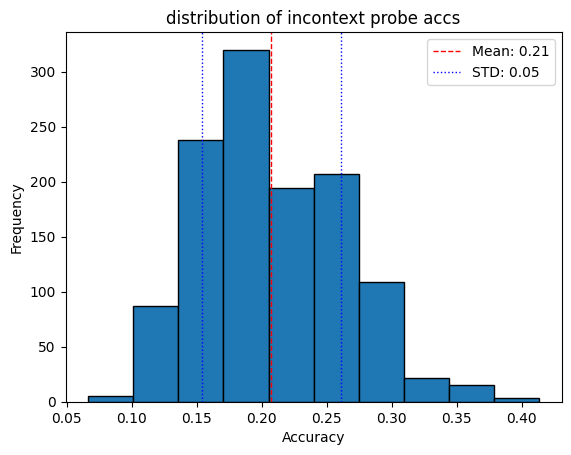

In [28]:
import numpy as np
import matplotlib.pyplot as plt

def histogram(arr, title):

    mean_tqa = np.mean(arr)
    std_tqa = np.std(arr)

    # Plot histogram
    plt.hist(arr, bins=10, edgecolor='black')

    # Add vertical lines for mean and standard deviation
    plt.axvline(mean_tqa, color='r', linestyle='dashed', linewidth=1, label=f'Mean: {mean_tqa:.2f}')
    plt.axvline(mean_tqa - std_tqa, color='b', linestyle='dotted', linewidth=1, label=f'STD: {std_tqa:.2f}')
    plt.axvline(mean_tqa + std_tqa, color='b', linestyle='dotted', linewidth=1)

    # Set title and labels
    plt.title(title)
    plt.xlabel('Accuracy')
    plt.ylabel('Frequency')

    # Add a legend
    plt.legend()

    # Show plot
    plt.show()

histogram(all_head_accs_np, title = "distribution of incontext probe accs")

In [45]:
# a = -np.sort(-all_head_accs_np.reshape(nin_d.model.cfg.n_layers, nin_d.model.cfg.n_heads), axis = 1)
#layer 21, head 13
px.imshow(np.array(total_accs).reshape(nin_d.model.cfg.n_layers, nin_d.model.cfg.n_heads), labels = {"x" : "Heads (sorted)", "y": "Layers"},title = "Sorted Probe Accuracies on Capitals", color_continuous_midpoint = 0, color_continuous_scale="RdBu", origin = "lower")


In [53]:
nin_d.dataset[98]

{'input': 'Q: What is the capital of Transnistria? A: Georgetown\nQ: What is the capital of Solomon Islands? A: Marigot\nQ: What is the capital of Ghana? A: Managua\nQ: What is the capital of Faroe Islands? A: Tórshavn\nQ: What is the capital of Kuwait? A: Havana\nQ: What is the capital of Iceland? A:',
 'label': 'Reykjavík',
 'n_few_shot': 5,
 'prop_wrong': 0.8752982456752721,
 'n_correct': 1,
 'model_correct': 1}

In [47]:
a = -np.sort(-np.array(total_accs).reshape(nin_d.model.cfg.n_layers, nin_d.model.cfg.n_heads), axis = 1)

px.imshow(a, labels = {"x" : "Heads (sorted)", "y": "Layers"},title = "Sorted Probe Accuracies on Capitals", color_continuous_midpoint = 0, color_continuous_scale="RdBu", origin = "lower")
